In [1]:
from imports.ExtractContactCases import ExtractContactCases

ex = ExtractContactCases('contact_extraction1')
samples = ex.load()

In [2]:
import pandas as pd
import numpy as np

centroids_ = pd.read_csv('centroids.csv')
centroids_.head()

,centroid-0,centroid-1,label
0,50.034483,153.551724,2
1,54.471910,180.449438,3
2,55.947368,126.750000,4
3,69.600000,153.566667,5
4,69.588889,202.411111,6


In [3]:
cents = centroids_.values[:, :2][:, ::-1]
cents

array([[153.55172414,  50.03448276],
       [180.4494382 ,  54.47191011],
       [126.75      ,  55.94736842],
       [153.56666667,  69.6       ],
       [202.41111111,  69.58888889],
       [104.85714286,  71.85714286],
       [173.04123711,  72.40206186],
       [134.4       ,  73.45555556],
       [190.61832061,  83.54961832],
       [118.56818182,  85.32954545],
       [154.        ,  86.        ],
       [170.94736842,  90.13157895],
       [136.64705882,  91.38823529],
       [219.09333333,  92.90666667],
       [ 89.42696629,  94.30337079],
       [201.71764706,  99.54117647],
       [106.66666667, 101.37333333],
       [154.94594595, 103.10810811],
       [183.75675676, 103.04054054],
       [124.41975309, 103.7654321 ],
       [142.60294118, 108.98529412],
       [166.88461538, 108.48076923],
       [171.36923077, 120.04615385],
       [189.        , 120.29333333],
       [225.        , 118.        ],
       [137.10294118, 120.41176471],
       [155.29310345, 120.29310345],
 

In [4]:
from sklearn.model_selection import train_test_split
from torch_geometric import seed_everything
seed_everything(0)

sample_idx = list(samples.keys())
cases = [str(samples[s_idx]['case']) for s_idx in sample_idx]

train_idx, val_test_idx = train_test_split(sample_idx, test_size=1-0.6, random_state=0) #fixed across extractions

cases = [str(samples[s_idx]['case']) for s_idx in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx,  test_size=0.5, random_state=0) #fixed across extractions

In [5]:
from scipy.spatial.distance import cdist
from imports.TactileDataset import cases_dict, list_of_rotations

X_train = np.zeros((len(train_idx), 53))
y_train = np.zeros((len(train_idx), 2))

for i, sample_idx in enumerate(train_idx):
    pos = np.array(samples[sample_idx]['events'])[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
        X_train[i, node_idx] = sum(events_idx)
    y_train[i] = cases_dict[samples[sample_idx]['case']]

In [6]:
X_val = np.zeros((len(val_idx), 53))
y_val = np.zeros((len(val_idx), 2))

for i, sample_idx in enumerate(val_idx):
    pos = np.array(samples[sample_idx]['events'])[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
        X_val[i, node_idx] = sum(events_idx)
    y_val[i] = cases_dict[samples[sample_idx]['case']]

In [7]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=300, max_depth=3)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [8]:
np.degrees(np.mean(np.abs(reg.predict(X_train) - y_train)))

0.032738284623992524

In [9]:
np.degrees(np.mean(np.abs(reg.predict(X_val) - y_val)))

0.8712706492813038

In [10]:
y_val[:5]

array([[-3.22494794e-02,  1.33581718e-02],
       [-4.40085947e-02,  1.06246146e-01],
       [ 2.46826830e-02, -2.46826830e-02],
       [-2.11251573e-17, -1.15000000e-01],
       [-1.15000000e-01,  1.40834382e-17]])

In [11]:
reg.predict(X_val)[:5]

array([[-0.04112528, -0.01394902],
       [-0.04515317,  0.11426168],
       [ 0.01290818, -0.02871226],
       [ 0.00038571, -0.11486316],
       [-0.13163242,  0.00991047]], dtype=float32)

In [25]:
np.degrees(np.max(np.abs(reg.predict(X_val) - y_val)))

4.793908873520726

In [13]:
np.degrees(np.median(np.abs(reg.predict(X_val) - y_val)))

0.7170014188113919

(array([93., 69., 48., 24., 16.,  5.,  1.,  1.,  0.,  1.]),
 array([0.00784051, 0.48644735, 0.96505418, 1.44366102, 1.92226786,
        2.40087469, 2.87948153, 3.35808836, 3.8366952 , 4.31530204,
        4.79390887]),
 <BarContainer object of 10 artists>)

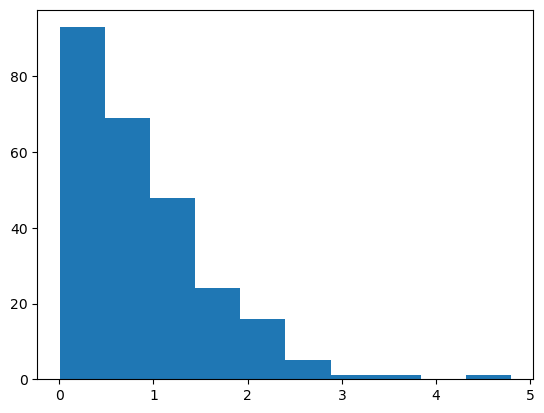

In [14]:
import matplotlib.pyplot as plt

plt.hist(np.degrees(np.abs(reg.predict(X_val) - y_val).ravel()))

In [15]:
from scipy.spatial.distance import cdist
from imports.TactileDataset import cases_dict, list_of_rotations

X_train_delta_r = np.zeros((len(train_idx), 53))
y_train_delta_r = np.zeros((len(train_idx), 2))

for i, sample_idx in enumerate(train_idx):
    
    sample = np.array(samples[sample_idx]['events'])
    
    pos = sample[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    center = (120.537313, 153.835821)
    center = np.array(center)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
                
        pos_events_idx = sample[events_idx, 3] == 1
        neg_events_idx = sample[events_idx, 3] == 0

        n_events = sum(events_idx) #1

        n_pos_events = sum(pos_events_idx) #2
        n_neg_events = n_events - n_pos_events #3
        
        r = np.linalg.norm(sample[events_idx, :2] - center, axis=-1) 

        r_pos = np.median(r[pos_events_idx]) if n_pos_events > 0 else 0
        r_neg = np.median(r[neg_events_idx]) if n_neg_events > 0 else 0
        delta_r = r_pos - r_neg if n_neg_events*n_pos_events > 0 else 0
        
        
        X_train_delta_r[i, node_idx] = delta_r
    y_train_delta_r[i] = cases_dict[samples[sample_idx]['case']]

In [16]:
from scipy.spatial.distance import cdist
from imports.TactileDataset import cases_dict, list_of_rotations

X_val_delta_r = np.zeros((len(val_idx), 53))
y_val_delta_r = np.zeros((len(val_idx), 2))

for i, sample_idx in enumerate(val_idx):
    
    sample = np.array(samples[sample_idx]['events'])
    
    pos = sample[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    center = (120.537313, 153.835821)
    center = np.array(center)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
                
        pos_events_idx = sample[events_idx, 3] == 1
        neg_events_idx = sample[events_idx, 3] == 0

        n_events = sum(events_idx) #1

        n_pos_events = sum(pos_events_idx) #2
        n_neg_events = n_events - n_pos_events #3
        
        r = np.linalg.norm(sample[events_idx, :2] - center, axis=-1) 

        r_pos = np.median(r[pos_events_idx]) if n_pos_events > 0 else 0
        r_neg = np.median(r[neg_events_idx]) if n_neg_events > 0 else 0
        delta_r = r_pos - r_neg if n_neg_events*n_pos_events > 0 else 0
        
        
        X_val_delta_r[i, node_idx] = delta_r
    y_val_delta_r[i] = cases_dict[samples[sample_idx]['case']]

In [17]:
import xgboost as xgb

reg_delta_r = xgb.XGBRegressor(n_estimators=300, max_depth=3, gamma=1e-2)
reg_delta_r.fit(X_train_delta_r, y_train_delta_r)#, eval_set = [(X_val_delta_r[j, :].reshape(1, -1), y_val_delta_r[j]) for j in range(len(X_val_delta_r))])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.01, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [19]:
np.degrees(np.mean(np.abs(reg_delta_r.predict(X_train_delta_r) - y_train_delta_r)))

0.9332771738019752

In [20]:
np.degrees(np.mean(np.abs(reg_delta_r.predict(X_val_delta_r) - y_val_delta_r)))

1.2389190670660166

In [21]:
from sklearn.decomposition import PCA

pca = PCA(2)
X_train_pca = pca.fit_transform(X_train)

In [22]:
case_train = np.array([samples[s_idx]['case'] for s_idx in train_idx], dtype=np.float64)

<AxesSubplot:>

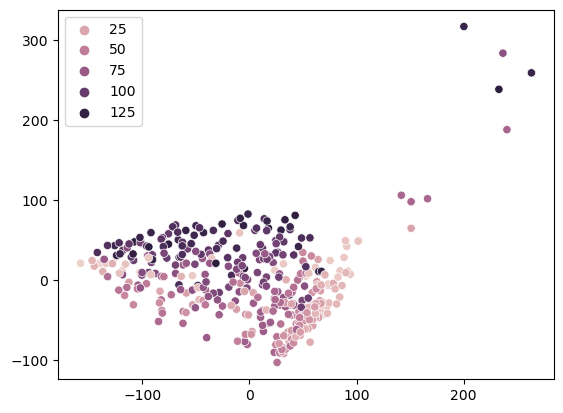

In [23]:
import seaborn as sns
sns.scatterplot(x=X_train_pca.T[0], y=X_train_pca.T[1], hue=case_train)

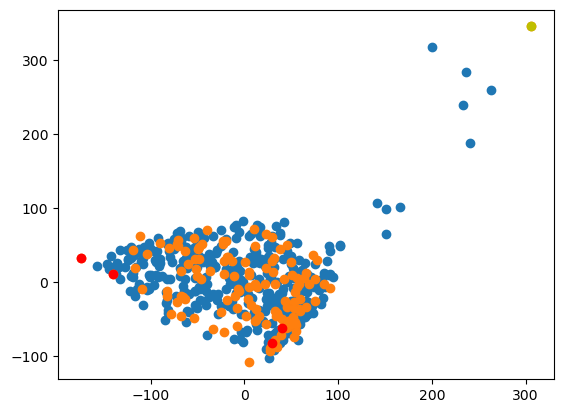

In [56]:
X_val_pca = pca.transform(X_val)
plt.scatter(*X_train_pca.T)
plt.scatter(*X_val_pca.T)
plt.scatter(*X_val_pca[[73, 121,  64, 118]].T, c='r')
plt.scatter(*X_val_pca[15, :].T, c='y')

In [55]:
np.argmax(X_val_pca, axis=0)

array([15, 15])

In [58]:
np.abs(reg.predict(X_val) - y_val)[15]

array([0.02042019, 0.00580809])

In [70]:
val_idx[73]

'sample_240'

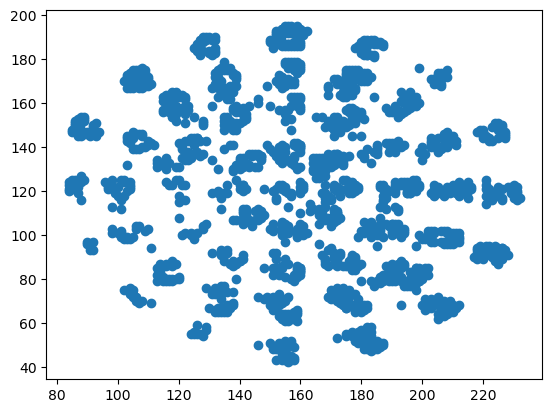

In [71]:
plt.scatter(*np.array(samples['sample_240']['events'])[:, :2].T)

In [73]:
np.array(samples['sample_240']['events']).shape

(1859, 4)

In [74]:
cases_dict[samples['sample_240']['case']]

[-0.10606601717798211, 0.10606601717798213]

In [42]:
np.degrees(np.sort(np.mean(np.abs(reg.predict(X_val) - y_val), axis=-1)))

array([0.01497006, 0.13647483, 0.13675351, 0.16006304, 0.1945272 ,
       0.21601497, 0.22436106, 0.22601067, 0.2607176 , 0.26241769,
       0.27395578, 0.27602651, 0.30464755, 0.3148504 , 0.3159264 ,
       0.31746783, 0.34314119, 0.35218591, 0.3934506 , 0.40363089,
       0.41466179, 0.43935895, 0.44079076, 0.45275352, 0.45444671,
       0.45671023, 0.45864138, 0.45888288, 0.47464949, 0.47566219,
       0.47942024, 0.48689093, 0.49066999, 0.49189376, 0.50310537,
       0.50493999, 0.51589523, 0.52357957, 0.53436335, 0.54167765,
       0.54579415, 0.55256189, 0.576561  , 0.60861528, 0.62016546,
       0.62272563, 0.63617824, 0.6473819 , 0.65458702, 0.65792397,
       0.67611395, 0.69423697, 0.69474037, 0.69854554, 0.70445589,
       0.70518536, 0.72147442, 0.73379456, 0.73711088, 0.74517071,
       0.75138488, 0.76039763, 0.76368928, 0.76442869, 0.77914902,
       0.78559215, 0.80618837, 0.8200744 , 0.820908  , 0.8229947 ,
       0.82780432, 0.8357832 , 0.84659597, 0.84810282, 0.85124

In [43]:
np.argsort(np.mean(np.abs(reg.predict(X_val) - y_val), axis=-1))

array([  3,   5,  94,  45,  43, 127, 106,  34,  84,   1, 120,  72,  89,
        93,  29,  36,  53,  76,  60,  42,   7,  52, 114,   2,  95, 113,
         9,  41,  58, 102,  78,  27,  91,  63,  46,  22,  90,  49,  13,
        65,  77, 104, 109,  98, 115,   6,  74,  51, 107,  69,  17,  48,
        70,  25,  38, 110,  57,  54,  24,  67,  15,   4,  80, 105,  96,
       117,   8,  61,  11,  47,  82, 128,  19, 123,  50, 103,  66, 116,
        16,  44,  28,  12,  75,  32,  68,  31,  55,   0, 112, 124,  85,
        99, 101, 119,  79,  10,  33,  59,  87,  37,  92,  86, 126,  18,
        62, 111, 108,  20,  40,  88, 100,  97,  39,  30,  56,  81,  14,
        26,  21,  71,  83, 125, 122,  35,  23,  73, 121,  64, 118])